In [1]:
import sys
sys.path.append("../src")

In [2]:
print(sys.path)

['/Users/lukaszbala/Documents/Python/adthena_task/notebooks', '/Users/lukaszbala/Documents/Python/adthena_task/notebooks', '/Users/lukaszbala/.local/bin', '/Users/lukaszbala/Library/Python/3.8/bin', '/Users/lukaszbala/anaconda3/lib/python38.zip', '/Users/lukaszbala/anaconda3/lib/python3.8', '/Users/lukaszbala/anaconda3/lib/python3.8/lib-dynload', '', '/Users/lukaszbala/Library/Caches/pypoetry/virtualenvs/adthena-task-fBQ-NFEo-py3.8/lib/python3.8/site-packages', '/Users/lukaszbala/Documents/Python/adthena_task/src', '/Users/lukaszbala/Library/Caches/pypoetry/virtualenvs/adthena-task-fBQ-NFEo-py3.8/lib/python3.8/site-packages/IPython/extensions', '/Users/lukaszbala/.ipython', '../src']


In [34]:
!pip install gensim seaborn

     |████████████████████████████████| 285 kB 1.0 MB/s eta 0:00:01
You should consider upgrading via the '/Users/lukaszbala/Library/Caches/pypoetry/virtualenvs/adthena-task-fBQ-NFEo-py3.8/bin/python -m pip install --upgrade pip' command.


In [35]:
from functools import partial
import multiprocessing
import random

from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import wordpunct_tokenize, word_tokenize
import pandas as pd
import numpy as np
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
import seaborn as sns
import string
import tensorflow as tf
from tqdm import tqdm

from adthena_task.config import Config

%matplotlib inline

In [5]:
config = Config()

In [6]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lukaszbala/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lukaszbala/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
np.random.seed(config.SEED)
random.seed(config.SEED)

In [8]:
def clean_text(text, stemmer):
    text = str(text).lower()
    tokens = [stemmer.stem(word) for word in wordpunct_tokenize(text) if word not in list(stop_words) + list(string.punctuation)]
    text = " ".join(tokens)
    return text

In [9]:
data = pd.read_csv(config.DATA_DIR_TRAIN, header=None)
data.columns = ["Query", "Label"]
data = utils.shuffle(data, random_state=config.SEED)

In [10]:
stop_words = set(stopwords.words("english"))
stemmer = SnowballStemmer(language="english")

In [11]:
clean_text_partial = partial(clean_text, stemmer=stemmer)

In [12]:
data["Clean_query"] = data["Query"].apply(clean_text_partial)

In [13]:
data_prev = data.copy()
data = data.iloc[:int(1e4), :]

In [14]:
train, val = train_test_split(data, test_size=config.TEST_SIZE, random_state=config.SEED)
val, test = train_test_split(val, test_size=config.TEST_SIZE, random_state=config.SEED)
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r["Clean_query"]), tags=[r["Label"]]), axis=1)
val_tagged = val.apply(
    lambda r: TaggedDocument(words=tokenize_text(r["Clean_query"]), tags=[r["Label"]]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r["Clean_query"]), tags=[r["Label"]]), axis=1)

In [15]:
# !wget http://nlp.stanford.edu/data/wordvecs/glove.6B.zip
# !unzip glove.6B.zip

In [16]:
glove = pd.read_csv('glove.6B.100d.txt', sep=" ", quoting=3, header=None, index_col=0)
glove_embedding = {key: val.values for key, val in glove.T.items()}

In [17]:
def create_embedding_matrix(word_index,embedding_dict,dimension):
    embedding_matrix=np.zeros((len(word_index)+1,dimension))

    for word,index in word_index.items():
        if word in embedding_dict:
            embedding_matrix[index]=embedding_dict[word]
    return embedding_matrix

text=["The cat sat on mat","we can play with model"]

tokenizer=tf.keras.preprocessing.text.Tokenizer(split=" ")
tokenizer.fit_on_texts(text)

text_token=tokenizer.texts_to_sequences(text)

embedding_matrix=create_embedding_matrix(tokenizer.word_index,embedding_dict=glove_embedding,dimension=100)

In [18]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [21]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [22]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 3945/3945 [00:00<00:00, 399500.92it/s]


In [23]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 3945/3945 [00:00<00:00, 2280078.45it/s]


In [24]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_val, X_val = vec_for_learning(model_dbow, val_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [29]:
logreg = LogisticRegression(n_jobs=cores, C=1e5, verbose=True)
logreg.fit(X_train, y_train)
y_pred_val = logreg.predict(X_val)
y_pred = logreg.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score
print('Validation accuracy %s' % accuracy_score(y_val, y_pred_val))
print('Validation F1 score: {}'.format(f1_score(y_val, y_pred_val, average='weighted')))
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Validation accuracy 0.6181541582150102
Validation F1 score: 0.6210133433326678
Testing accuracy 0.6188545362392296
Testing F1 score: 0.6224253613739217


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    2.4s finished


In [30]:
## Confusion matrix

In [36]:
conf_matrix = confusion_matrix(y_test, y_pred)

Text(0.5, 33.0, 'Predicted label')

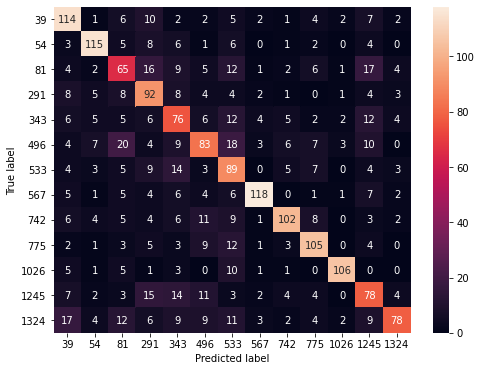

In [37]:
fig, ax = plt.subplots(figsize=(8, 6))
df_cm = pd.DataFrame(conf_matrix, index=logreg.classes_, columns=logreg.classes_)
sns.heatmap(df_cm,annot=True, fmt="d", ax=ax)
plt.ylabel("True label")
plt.xlabel("Predicted label")